In [38]:
#Install the haversine Package
pip install haversine

SyntaxError: invalid syntax (105500189.py, line 2)

In [41]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
#Load the dataset
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")

#Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [16]:
#Feature Engineering 

#Extracting Latitude and Longitude

def extract_lat_lon(location_str):
    lat, lon = location_str.strip("()").split(",")
    return float(lat), float(lon)

df['Customer_Lat'], df['Customer_Lon'] = zip(*df['Customer_Location'].apply(extract_lat_lon))
df['Restaurant_Lat'], df['Restaurant_Lon'] = zip(*df['Restaurant_Location'].apply(extract_lat_lon))

In [42]:
#Calculating Haversine Distance

df['Calculated_Distance'] = df.apply(lambda row: haversine(
    (row['Customer_Lat'], row['Customer_Lon']),
    (row['Restaurant_Lat'], row['Restaurant_Lon']),
    unit='km'), axis=1)

In [43]:
#Encoding Time and Priority

time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
df['Order_Time_Encoded'] = df['Order_Time'].map(time_mapping)

priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['Order_Priority_Encoded'] = df['Order_Priority'].map(priority_mapping)

In [20]:
#Adding a Weekend Feature

df['is_weekend'] = np.random.randint(0, 2, size=len(df))

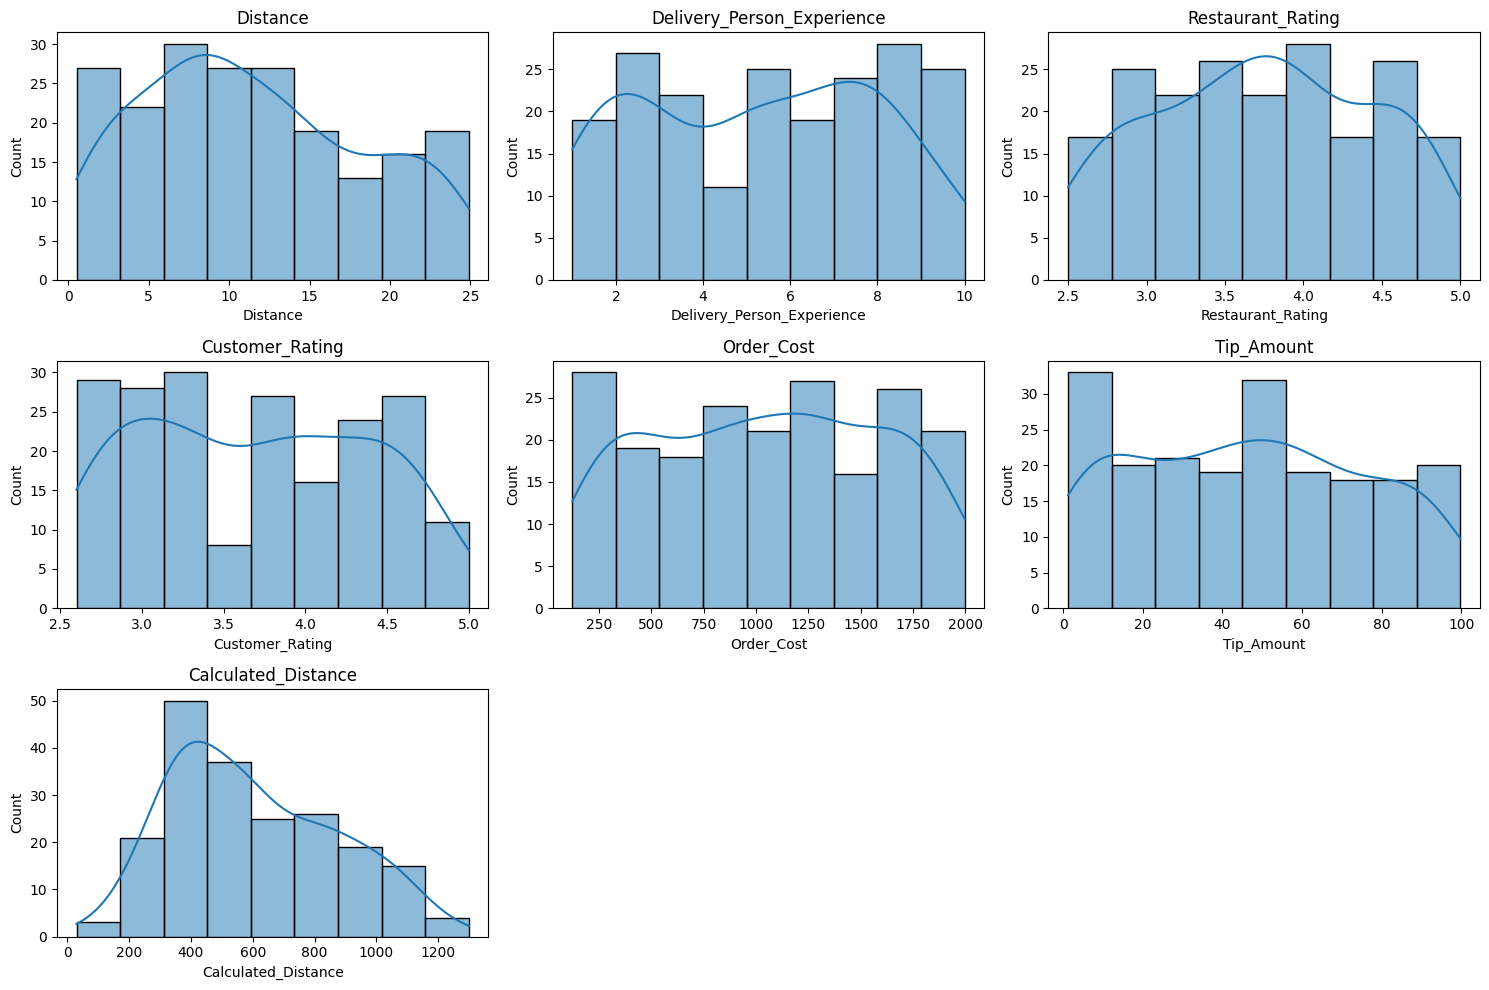

In [22]:
#Numeric Features Distribution

numeric_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 
                'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Calculated_Distance']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

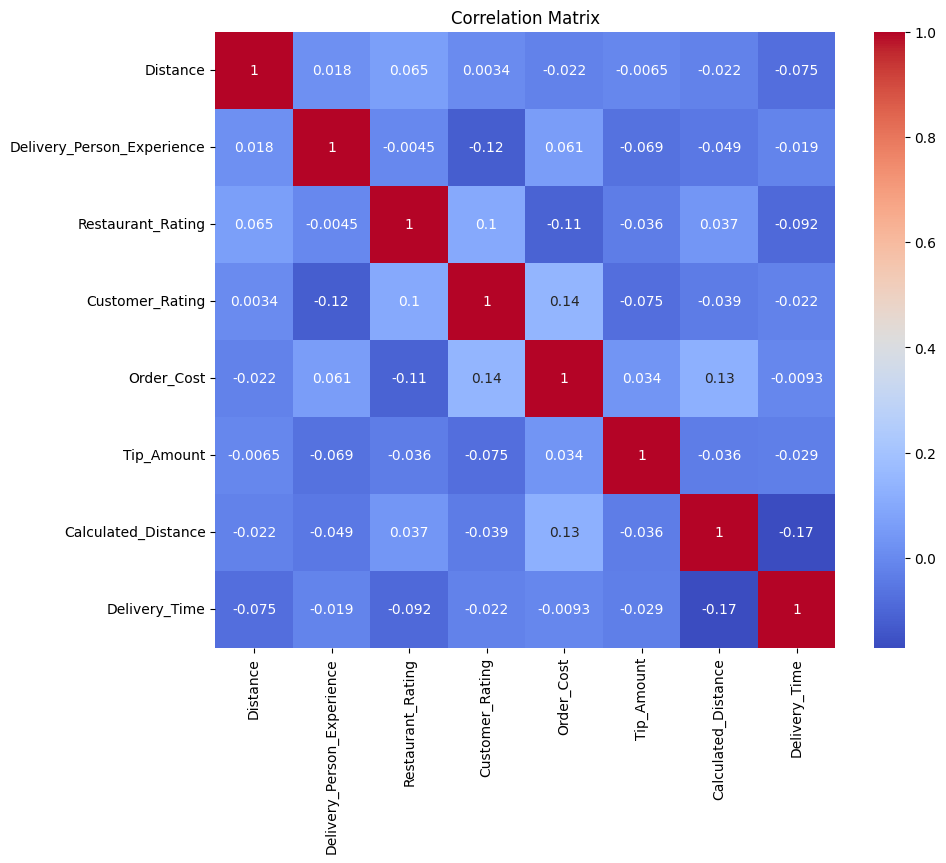

In [23]:
#Correlation Matrix

plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols + ['Delivery_Time']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

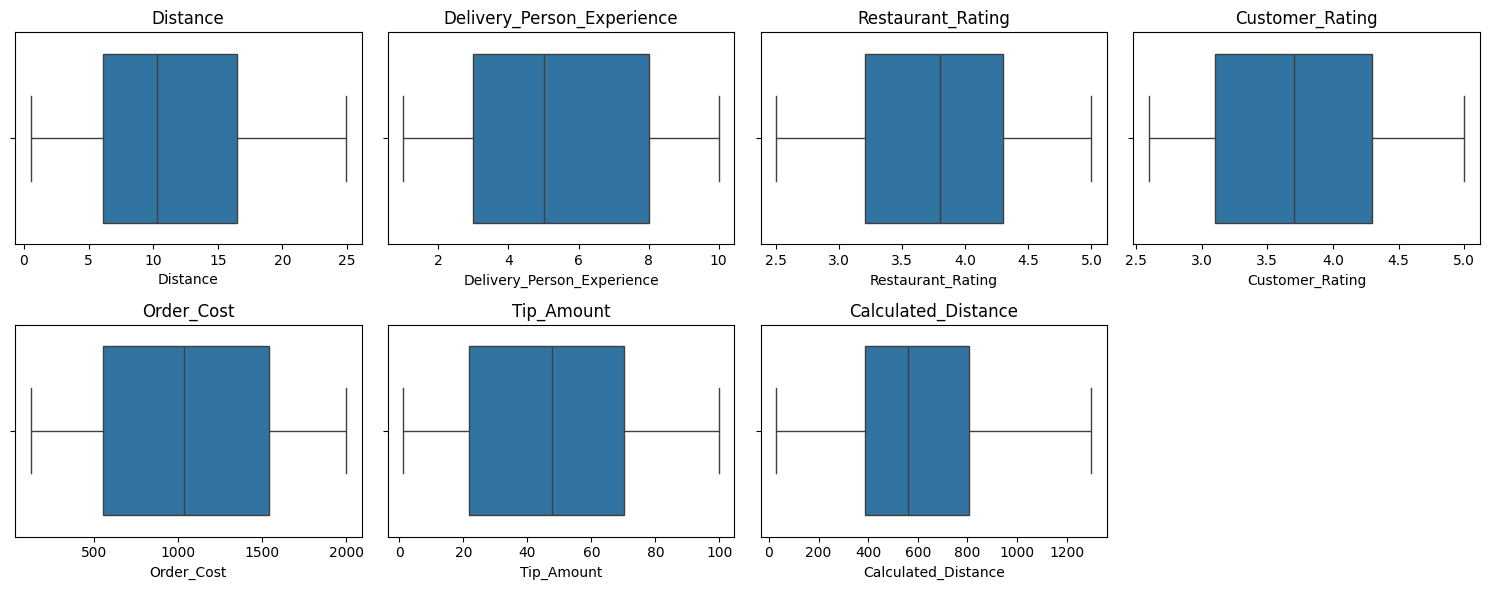

In [24]:
#Boxplots for Numeric Features

plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

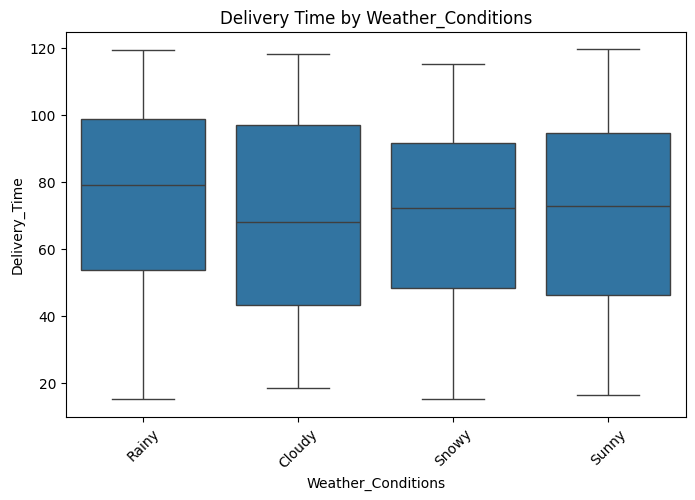

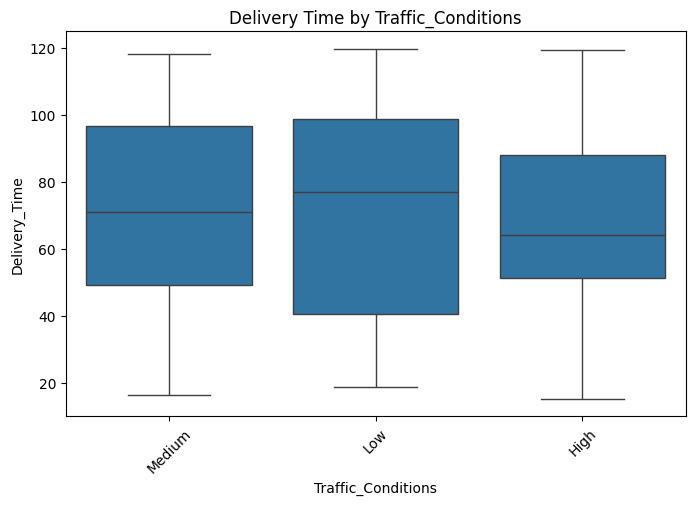

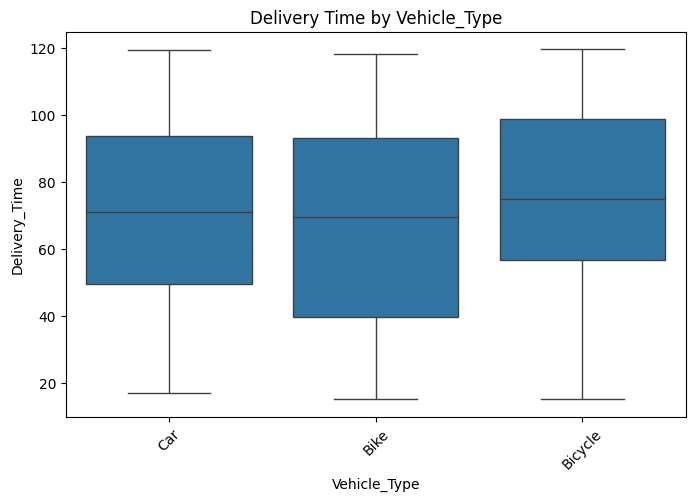

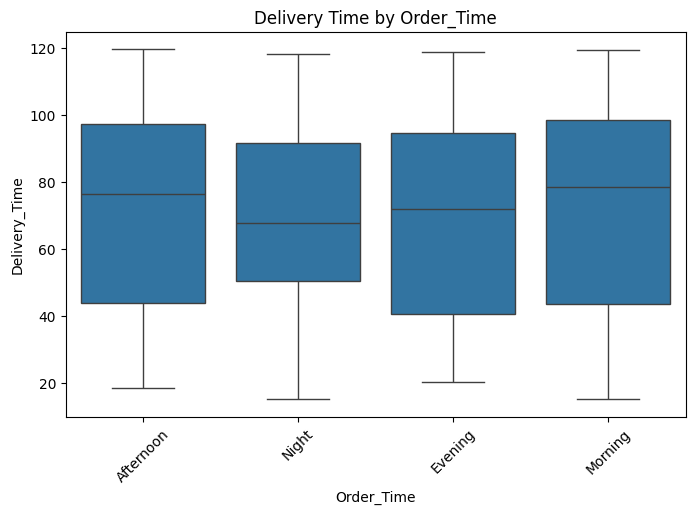

In [25]:
#Categorical Features Analysis

categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Order_Time']
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='Delivery_Time', data=df)
    plt.title(f'Delivery Time by {col}')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
#Defining Features and Target

X = df.drop(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Time'], axis=1)
y = df['Delivery_Time']

In [27]:
#Defining Categorical and Numeric Features

categorical_features = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Order_Time']
numeric_features = ['Distance', 'Delivery_Person_Experience', 'Order_Priority_Encoded',
                   'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount',
                   'Calculated_Distance', 'Order_Time_Encoded', 'is_weekend']

In [28]:
#Creating a Preprocessing Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [29]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#Model Training

#Linear Regression Pipeline

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

In [31]:
#Random Forest Pipeline

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [32]:
#Model Evaluation

#Linear Regression Metrics

print("\nLinear Regression Metrics:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression Metrics:
MSE: 948.3734897512106
R²: -0.025389235051754833
MAE: 26.413013158943482


In [44]:
#Random Forest Metrics

print("\nRandom Forest Metrics:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))


Random Forest Metrics:
MSE: 932.3112741540001
R²: -0.008022635138907663
MAE: 26.050595000000005


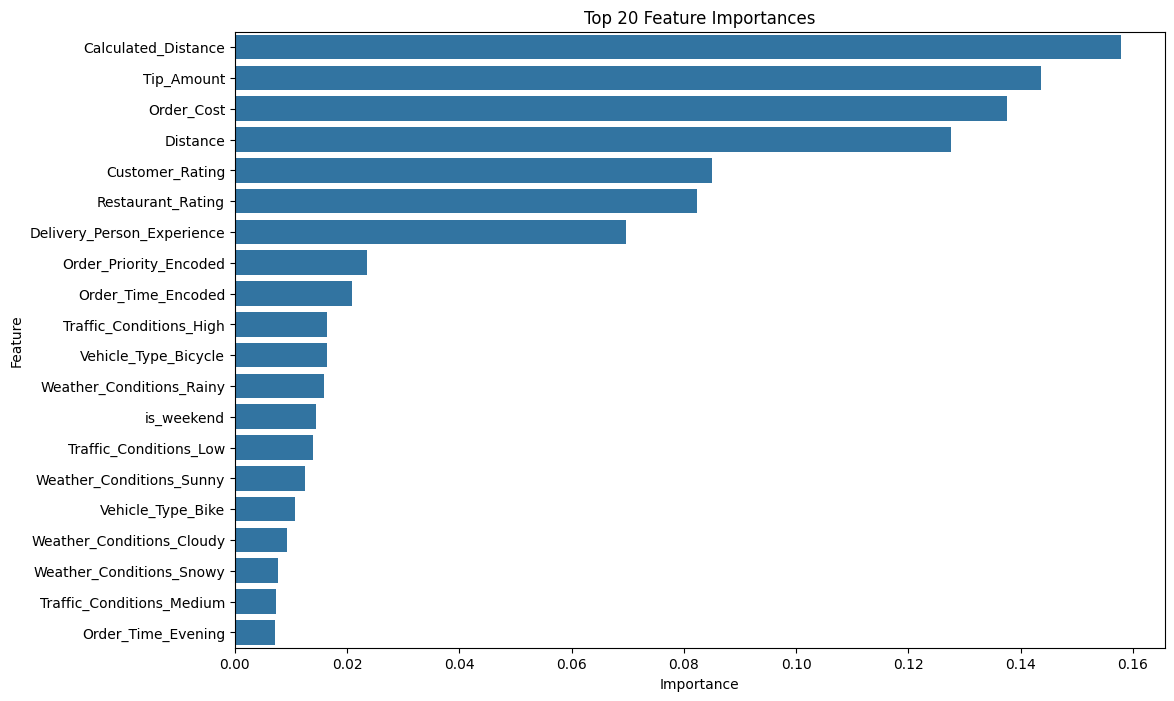

In [33]:
#Feature Importance (Random Forest)

cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

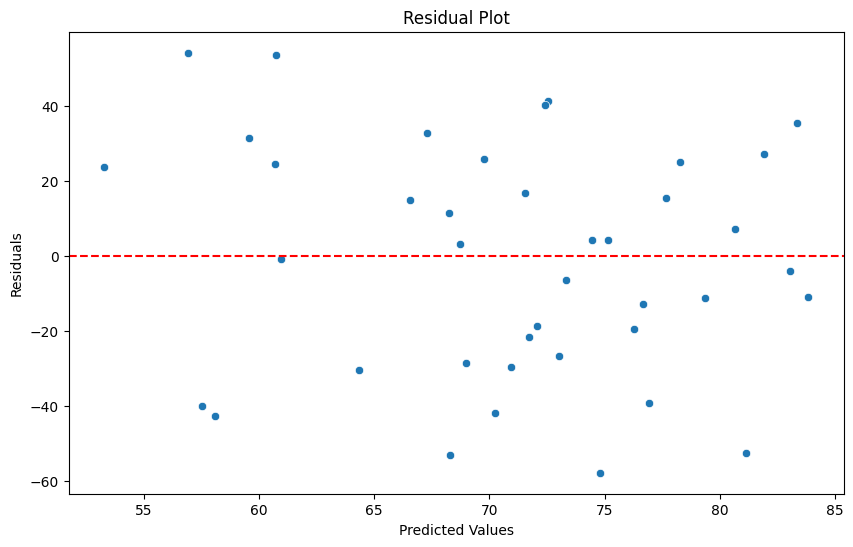

In [34]:
#Residual Plot

residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

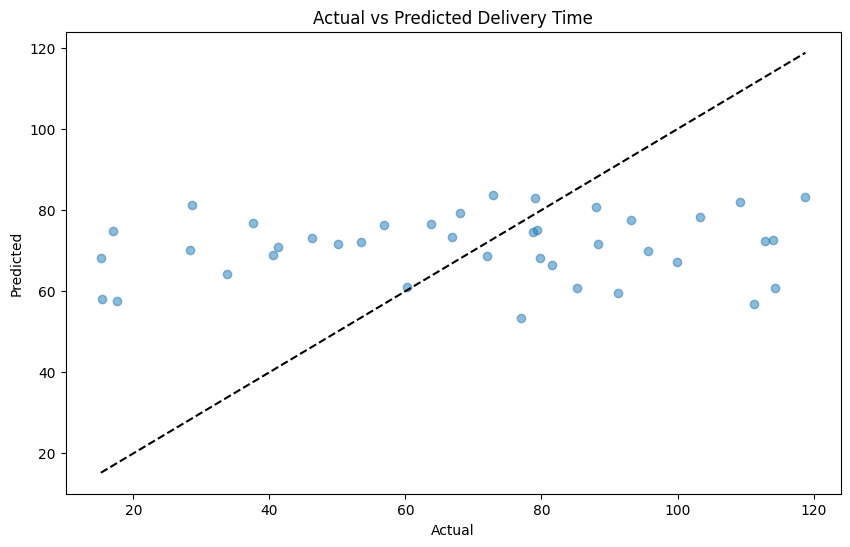

In [35]:
#Actual vs Predicted Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Delivery Time')
plt.show()